# Preliminaries

## Similarity and distance

Given an $n\times d$ feature matrix, we want to define disjoint subsets of the $\bfx_i$ such that the samples within a cluster are more similar to one another than they are to members of other clusters.

The first decision we have to make is how to measure *similarity*. Mostly we consider similarity to be inversely related to distance, which we can measure using a vector norm, and will describe clustering methods in terms of pairwise distances. 

We already have the 2-norm (Euclidean) and 1-norm (Manhattan) distances defined. Another important norm, especially in text processing, is *cosine distance*. Vector geometry shows that for vectors $\mathbf{u}$ and $\mathbf{v}$ in $\real^d$, the angle $\theta$ between the vectors satisfies

$$
\cos(\theta) = \frac{\mathbf{u}^T\mathbf{v}}{\twonorm{\mathbf{u}} \, \twonorm{\mathbf{v}}}.
$$

The **cosine distance** between $\mathbf{u}$ and $\mathbf{v}$ is $\tfrac{1}{2}[1-\cos(\theta)]$. This is zero when $\theta=0$ and has max value 1 at $\theta=\pi$. This metric is sensitive only to the relative directions of the vectors, not their geometric lengths. However, it does not meet all the requirements of a norm, such as the triangle inequality.

Clustering algorithms are concerned only with the similarities/distances between pairs of samples. As a result, many can be given the $n\times n$ **distance matrix** $\mathbf{D}$, defined by

$$
D_{ij} = \text{dist}(\bfx_i,\bfx_j), 
$$

instead of the feature matrix. Note that $D_{ii}=0$ and $D_{ji}=D_{ij}$.

### Toy example

Suppose we have sample points lying near the corners of a cube in 3D. This lets us compute an 8×8 distance matrix.

<AxesSubplot:>

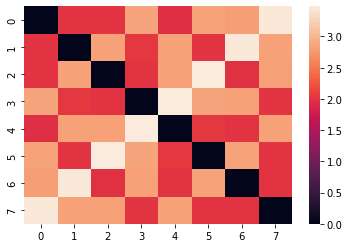

In [1]:
from sklearn.metrics import pairwise_distances
import seaborn as sns

X = [
    [-1.01,-1,-.98],[1,-1.02,-1],[-.98,1,-.99],[1.01,1.01,-1], 
    [-1.01,-1.01,.99],[1.02,-1.02,1],[-.99,.98,.99],[1,.98,1], 
]

D2 = pairwise_distances(X,metric="euclidean")
sns.heatmap(D2)

Note the symmetry. Changing to a different norm is trivial.

<AxesSubplot:>

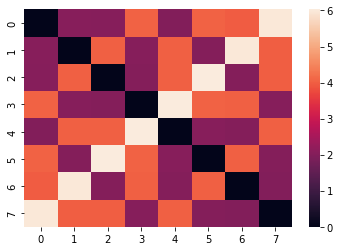

In [2]:
D1 = pairwise_distances(X,metric="manhattan")
sns.heatmap(D1)

## Performance metrics

If a trusted or ground truth clustering is available, then we can compare it to a different clustering result. Let's say that two sample points in a clustering are *buddies* if they are in the same cluster, and *strangers* otherwise. 

### (Adjusted) Rand index
Let $b$ be the number of pairs that are buddies in both clusterings, and let $s$ be the number of pairs that are strangers in both clusterings. Noting that there are $\binom{n}{2}$ distinct pairs of $n$ sample points, we define the **Rand index** by

$$
\text{RI} = \frac{b+s}{\binom{n}{2}}.
$$

While the Rand index is not hard to understand, it's not normalized to any obvious scale. The **adjusted Rand index** is

$$
\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\text{max}(\text{RI})-E[\text{RI}]},
$$

where the mean and max operations are taken over all possible clusterings. (These values can be worked out by probabilistic reasoning.) Hence an ARI of 0 indicates no better agreement than a random clustering, and an ARI of 1 is maximum agreement. 

### Silhouette coefficient

If no reference clustering (i.e., ground truth) is available, then we can use a different measurement to assess the intrinsic quality. Suppose $\bfx_i$ is a sample point. Let $\bar{b}$ be the mean distance between $\bfx_i$ and its buddies, and let $\bar{r}$ be the mean distance between $\bfx_i$ and the members of the nearest cluster of strangers. Then the **silhouette coefficient** or silhouette score of $\bfx_i$ is 

$$
S_i = \frac{\bar{r}-\bar{b}}{\max\{\bar{r},\bar{b}\}}.
$$

This value is between $-1$ (bad) and $1$ (good). Finally, the silhouette score of a cluster is the mean of the $S_i$ over the samples in that cluster.

### Toy example

We will create an artificial data set with two features and three predefined clusters.

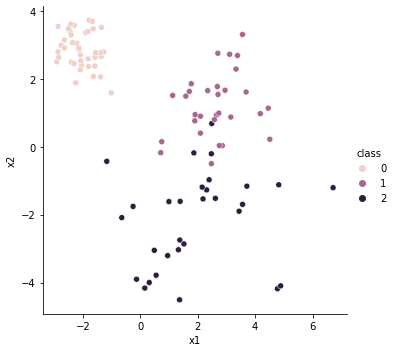

In [3]:
from sklearn.datasets import make_blobs
X,y = make_blobs(
    n_samples=[40,30,30],
    centers=[[-2,3],[3,1.5],[2,-2]],
    cluster_std=[0.5,0.9,1.5],
    random_state = 19716
    )

import pandas as pd
blobs = pd.DataFrame({"x1":X[:,0],"x2":X[:,1],"class":y})
sns.relplot(data=blobs,x="x1",y="x2",hue="class");

As you can see above, class 2 is more dispersed than the other clusters, and, given the overlaps, a person might label a few points differently.

We will add a column to the data frame that records the silhouette score for each point.

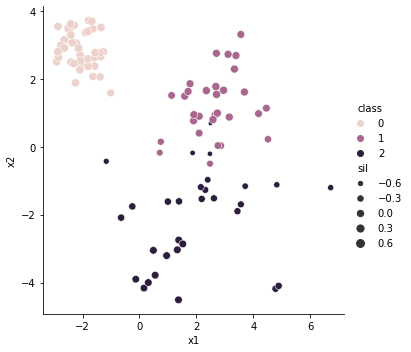

In [4]:
from sklearn.metrics import silhouette_samples
blobs["sil"] = silhouette_samples(X,y)
sns.relplot(data=blobs,x="x1",y="x2",hue="class",size="sil");

In this plot, the size of the dot shows its silhouette coefficient. Those points which don't belong comfortably with their cluster have negative scores and the smallest dots. We can find the average score in each cluster through a grouped mean:

In [5]:
blobs.groupby("class")["sil"].mean()

class
0    0.812718
1    0.551222
2    0.223225
Name: sil, dtype: float64

These values are ordered as we would expect.

Now let's create another clustering based on the quadrants of the plane.

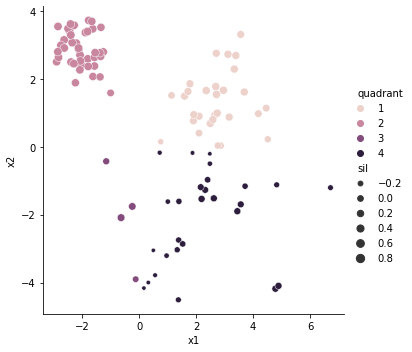

In [6]:
def quad(x,y):
    if x > 0:
        if y > 0: return 1
        else: return 4
    else:
        if y > 0: return 2
        else: return 3

blobs["quadrant"] = [quad(x,y) for (x,y) in zip(blobs.x1,blobs.x2)]
blobs["sil"] = silhouette_samples(X,blobs["quadrant"])
sns.relplot(data=blobs,x="x1",y="x2",hue="quadrant",size="sil");

In [7]:
blobs.groupby("quadrant")["sil"].mean()

quadrant
1    0.578120
2    0.808252
3    0.409983
4    0.043896
Name: sil, dtype: float64

Even though the original clustering had three classes, and there are four quadrants, we can still compare them by adjusted Rand index.

In [8]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(y,blobs["quadrant"])

0.8784845217926999

Not surprisingly, they are seen as fairly similar.